<a href="https://colab.research.google.com/github/ChangED1122/Python/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from pandas import read_csv
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [ ]:
data=read_csv("/content/BANK_EC_ALL.CSV")

dateparse = lambda x: pd.datetime.strptime(x, '%Y%m')
df = pd.read_csv(r'/content/BANK_EC_ALL.CSV',parse_dates=['年月'], date_parser=dateparse)
df

<ipython-input-2042-98ce3ee094b5>:3: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



,年月,信用卡交易金額[新台幣]
0,2014-01-01,1.332175e+10
1,2014-02-01,1.080860e+10
2,2014-03-01,1.311072e+10
3,2014-04-01,1.222969e+10
4,2014-05-01,1.292465e+10
...,...,...
105,2022-10-01,1.038190e+11
106,2022-11-01,1.098910e+11
107,2022-12-01,1.148490e+11
108,2023-01-01,1.022900e+11


In [ ]:
count = df[['信用卡交易金額[新台幣]']]
count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   信用卡交易金額[新台幣]  110 non-null    float64
dtypes: float64(1)
memory usage: 1008.0 bytes


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
count['信用卡交易金額[新台幣]'] = scaler.fit_transform(count['信用卡交易金額[新台幣]'].values.reshape(-1,1))

<ipython-input-2044-e7d08b57290e>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download
import matplotlib as mpl
import matplotlib.pyplot as plt 
from matplotlib.font_manager import fontManager

fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
mpl.rc('font', family='Taipei Sans TC Beta')

--2023-05-06 14:04:27--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 64.233.188.100, 64.233.188.139, 64.233.188.113, ...
Connecting to drive.google.com (drive.google.com)|64.233.188.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/8utu4gjankd91jgj31r6t2cgrfg44muf/1683381825000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_?uuid=f3c24fb9-c22c-40c3-bdf0-9400dcb49f4e [following]
--2023-05-06 14:04:31--  https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/8utu4gjankd91jgj31r6t2cgrfg44muf/1683381825000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_?uuid=f3c24fb9-c22c-40c3-bdf0-9400dcb49f4e
Resolving doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)... 74.125.204.132, 2404:6800:4008:c04::84
Connecting to doc-0k

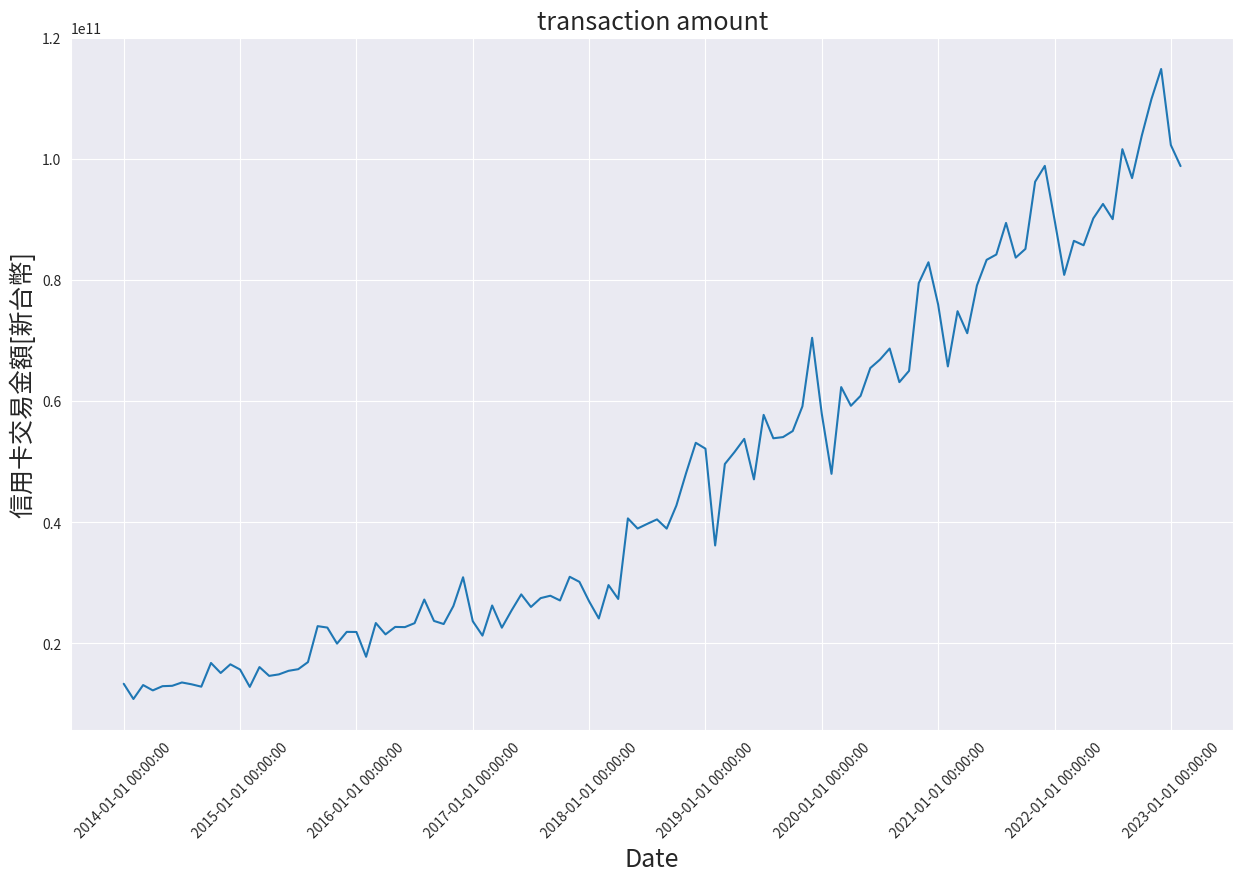

In [ ]:
import seaborn as sns

plt.figure(figsize = (15,9))
plt.plot(df[['信用卡交易金額[新台幣]']])
plt.xticks(range(0,df.shape[0],12),df['年月'].loc[::12],rotation=45)
plt.title("transaction amount",fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel("信用卡交易金額[新台幣]",fontsize=18)
plt.show()

In [ ]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [ ]:
lookback = 25 # choose sequence length
x_train, y_train, x_test, y_test = split_data(count, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)


x_train.shape =  (68, 24, 1)
y_train.shape =  (68, 1)
x_test.shape =  (17, 24, 1)
y_test.shape =  (17, 1)


In [ ]:
import torch
import torch.nn as nn

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)


In [ ]:
import random
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True

In [ ]:
input_dim = 1
hidden_dim = 128
num_layers = 2
output_dim = 1
num_epochs = 500

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [ ]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
setup_seed(20)
import time

hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.17722177505493164
Epoch  1 MSE:  0.1474558711051941
Epoch  2 MSE:  0.12026699632406235
Epoch  3 MSE:  0.09495291113853455
Epoch  4 MSE:  0.07147873193025589
Epoch  5 MSE:  0.05083155632019043
Epoch  6 MSE:  0.03618162125349045
Epoch  7 MSE:  0.0354214645922184
Epoch  8 MSE:  0.05000865086913109
Epoch  9 MSE:  0.05046533793210983
Epoch  10 MSE:  0.04195999726653099
Epoch  11 MSE:  0.035069409757852554
Epoch  12 MSE:  0.03223336115479469
Epoch  13 MSE:  0.03218577802181244
Epoch  14 MSE:  0.03333720192313194
Epoch  15 MSE:  0.03464892506599426
Epoch  16 MSE:  0.035584382712841034
Epoch  17 MSE:  0.0359250009059906
Epoch  18 MSE:  0.035635240375995636
Epoch  19 MSE:  0.03478506952524185
Epoch  20 MSE:  0.033509522676467896
Epoch  21 MSE:  0.03198804333806038
Epoch  22 MSE:  0.0304306298494339
Epoch  23 MSE:  0.029059747233986855
Epoch  24 MSE:  0.028076300397515297
Epoch  25 MSE:  0.027600418776273727
Epoch  26 MSE:  0.027592314407229424
Epoch  27 MSE:  0.0277980603277683

In [ ]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

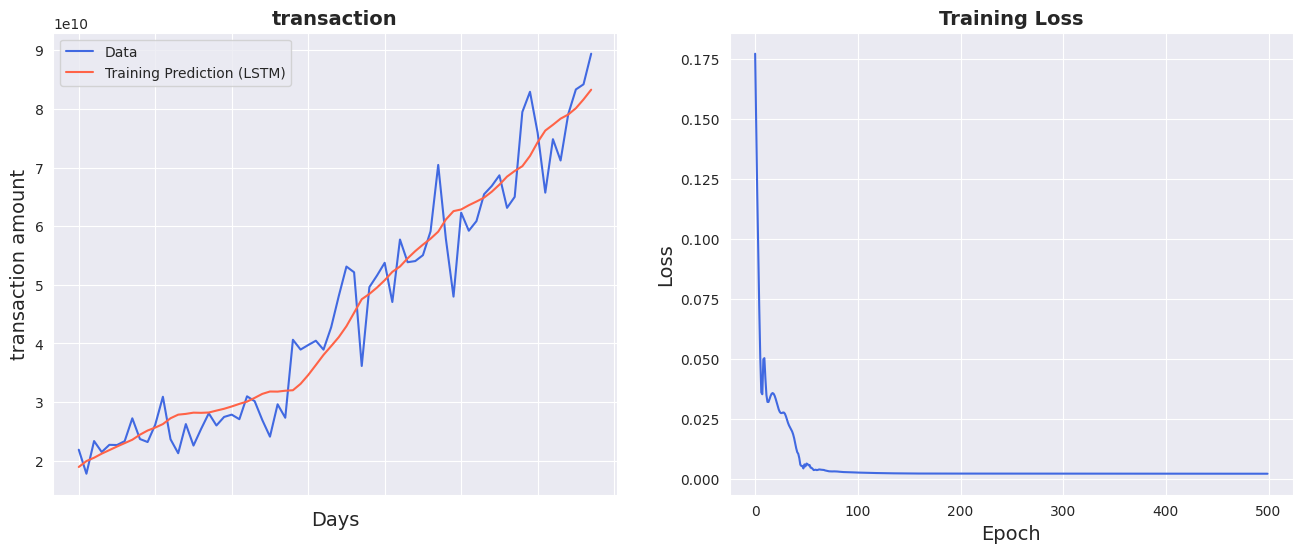

In [ ]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('transaction', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("transaction amount", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [ ]:
import math, time
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
testScore2 = math.sqrt(mean_absolute_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f MAE' % (testScore2))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)



Train Score: 5019564526.04 RMSE
Test Score: 7180495631.12 RMSE
Test Score: 79307.76 MAE


In [ ]:
trainPredictPlot = np.empty_like(count)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

testPredictPlot = np.empty_like(count)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(count)-1, :] = y_test_pred

original = scaler.inverse_transform(count['信用卡交易金額[新台幣]'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)
result

,0,1,2
0,NaN,NaN,1.332175e+10
1,NaN,NaN,1.080860e+10
2,NaN,NaN,1.311072e+10
3,NaN,NaN,1.222969e+10
4,NaN,NaN,1.292465e+10
...,...,...,...
105,NaN,1.020397e+11,1.038190e+11
106,NaN,1.037974e+11,1.098910e+11
107,NaN,1.060066e+11,1.148490e+11
108,NaN,1.086625e+11,1.022900e+11


In [ ]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='transaction amount',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,xanchor='left', yanchor='bottom',
                              text='Results (LSTM)',font=dict(family='Rockwell',size=26,color='white'),showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()

In [ ]:
df2=df.join(result[0])
df2=df2.join(result[1])
df2

,年月,信用卡交易金額[新台幣],0,1
0,2014-01-01,1.332175e+10,NaN,NaN
1,2014-02-01,1.080860e+10,NaN,NaN
2,2014-03-01,1.311072e+10,NaN,NaN
3,2014-04-01,1.222969e+10,NaN,NaN
4,2014-05-01,1.292465e+10,NaN,NaN
...,...,...,...,...
105,2022-10-01,1.038190e+11,NaN,1.020397e+11
106,2022-11-01,1.098910e+11,NaN,1.037974e+11
107,2022-12-01,1.148490e+11,NaN,1.060066e+11
108,2023-01-01,1.022900e+11,NaN,1.086625e+11


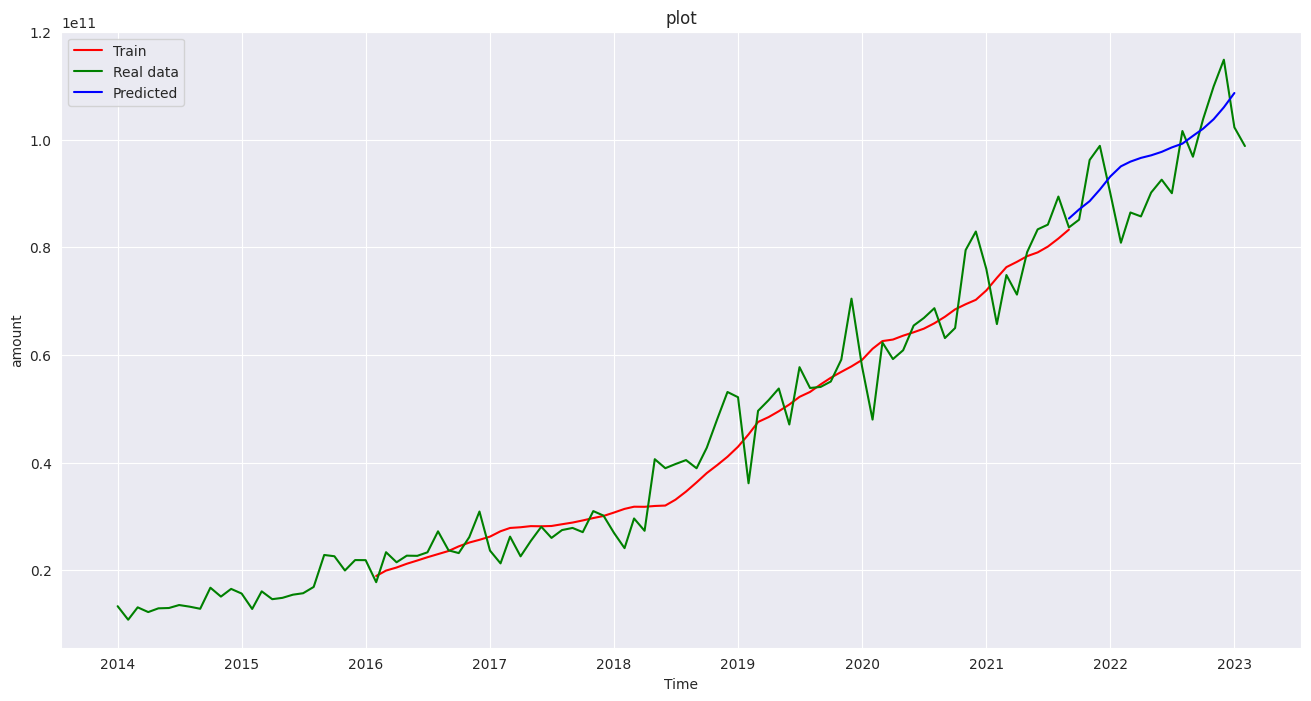

In [ ]:
plt.figure(figsize=(16,8))
plt.plot( df2["年月"], df2[0], color='red', label = 'Train')
plt.plot(df2["年月"], df["信用卡交易金額[新台幣]"], color = 'green', label = 'Real data')
plt.plot( df2["年月"], df2[1], color = 'blue', label = 'Predicted')

plt.title('plot')
plt.xlabel('Time')
plt.ylabel('amount')
plt.legend()
plt.grid(True)
plt.show()

,test,pred
0,8.369621e+10,8.534967e+10
1,8.513548e+10,8.703857e+10
2,9.622339e+10,8.857642e+10
3,9.884833e+10,9.072408e+10
4,8.998684e+10,9.317187e+10
5,8.084899e+10,9.504276e+10
6,8.646814e+10,9.591629e+10
7,8.573722e+10,9.661255e+10
8,9.017264e+10,9.708583e+10
9,9.256188e+10,9.773093e+10


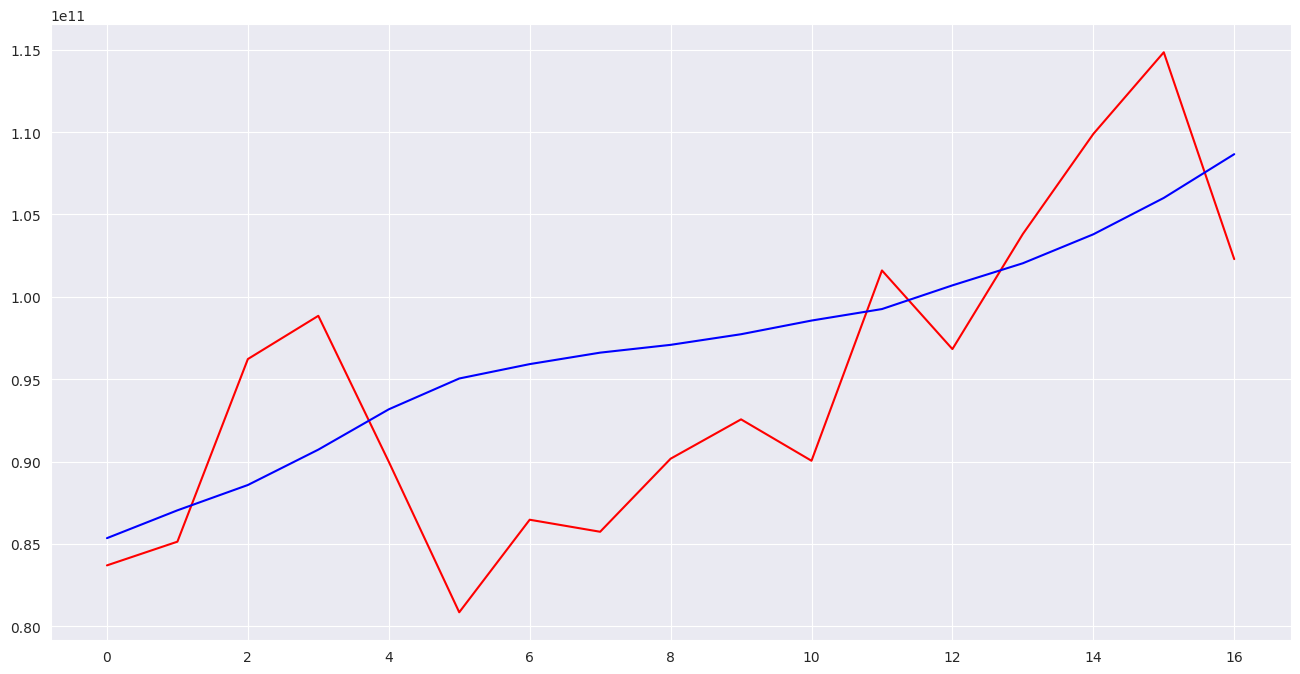

In [ ]:


a=pd.DataFrame({'test':y_test[:,0],'pred':y_test_pred[:,0]})
plt.figure(figsize=(16,8))
plt.plot( a["test"].index, a["test"], color='red', label = 'Test')
plt.plot( a["pred"].index, a["pred"], color = 'blue', label = 'Predicted')
a